###  Classification Targets

Target - the target is an ordinal variable indicating groups of income levels.

1 = extreme poverty \
2 = moderate poverty \
3 = vulnerable households \
4 = non vulnerable households


https://www.kaggle.com/competitions/costa-rican-household-poverty-prediction/data

### ✅ Setup

Install the required packages abd declare the global variables.

In [1]:
%pip install -r ../requirements.txt -q

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
from plotnine import *
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [3]:
DATA_DIR = '../data/'
TEST_CSV = DATA_DIR + 'test.csv'
TRAIN_CSV = DATA_DIR + 'train.csv'

TARGET_COLUMN = "Target"
ID_COLUMN = "Id"
HOUSE_HOLD_ID_COLUMN = "idhogar"

DEFAULT_RANDOM_STATE = 369
DEFAULT_TEST_SIZE = 0.3
DEFAULT_VALIDATION_SIZE = 0.3
DEFAULT_CROSS_VALIDATION = 4

### ✅ Visualization

In [4]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, test_x, test_y):
    predictions = model.predict(test_x)
    cm = confusion_matrix(test_y, predictions)

    plt.figure(figsize=(20, 20))
    plt.matshow(cm, cmap=plt.cm.Blues)

    plt.title('Confusion matrix')
    plt.colorbar()

    thresh = cm.max() / 2.
    for i, j in np.ndindex(cm.shape):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    class_labels = np.unique(test_y)
    print(class_labels)
    plt.xticks(np.arange(len(class_labels)), class_labels )
    plt.yticks(np.arange(len(class_labels)), class_labels)
      
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()

### ✅ Data Overview

In [5]:
csv_data = pd.read_csv(TRAIN_CSV)
csv_data.describe(include = 'all')

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
count,9557,2.697000e+03,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,2215.000000,9557.000000,...,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9557.000000,9552.000000,9557.000000,9557.000000
unique,9557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,ID_279628684,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,NaN,1.652316e+05,0.038087,4.955530,0.023648,0.994768,0.957623,0.231767,1.404063,0.385895,...,74.222769,1643.774302,19.132887,53.500262,3.844826,3.249485,3.900409,102.588867,1643.774302,3.302292
std,NaN,1.504571e+05,0.191417,1.468381,0.151957,0.072145,0.201459,0.421983,0.763131,0.680779,...,76.777549,1741.197050,18.751395,78.445804,6.946296,4.129547,12.511831,93.516890,1741.197050,1.009565
min,NaN,0.000000e+00,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,1.000000,0.000000,0.000000,0.040000,0.000000,0.000000,0.000000,1.000000
25%,NaN,8.000000e+04,0.000000,4.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,16.000000,289.000000,9.000000,0.000000,0.000000,1.000000,0.111111,36.000000,289.000000,3.000000
50%,NaN,1.300000e+05,0.000000,5.000000,0.000000,1.000000,1.000000,0.000000,1.000000,0.000000,...,36.000000,961.000000,16.000000,36.000000,1.000000,2.250000,0.444444,81.000000,961.000000,4.000000
75%,NaN,2.000000e+05,0.000000,6.000000,0.000000,1.000000,1.000000,0.000000,2.000000,1.000000,...,121.000000,2601.000000,25.000000,81.000000,4.000000,4.000000,1.777778,134.560010,2601.000000,4.000000


In [6]:
print(f"Total number of rows: {len(csv_data)}")

Total number of rows: 9557


In [7]:
csv_data.head()

,Id,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,...,SQBescolari,SQBage,SQBhogar_total,SQBedjefe,SQBhogar_nin,SQBovercrowding,SQBdependency,SQBmeaned,agesq,Target
0,ID_279628684,190000.0,0,3,0,1,1,0,NaN,0,...,100,1849,1,100,0,1.000000,0.0,100.0,1849,4
1,ID_f29eb3ddd,135000.0,0,4,0,1,1,1,1.0,0,...,144,4489,1,144,0,1.000000,64.0,144.0,4489,4
2,ID_68de51c94,NaN,0,8,0,1,1,0,NaN,0,...,121,8464,1,0,0,0.250000,64.0,121.0,8464,4
3,ID_d671db89c,180000.0,0,5,0,1,1,1,1.0,0,...,81,289,16,121,4,1.777778,1.0,121.0,289,4
4,ID_d56d6f5f5,180000.0,0,5,0,1,1,1,1.0,0,...,121,1369,16,121,4,1.777778,1.0,121.0,1369,4


Text(0.5, 1.0, 'Histogram of People by Class')

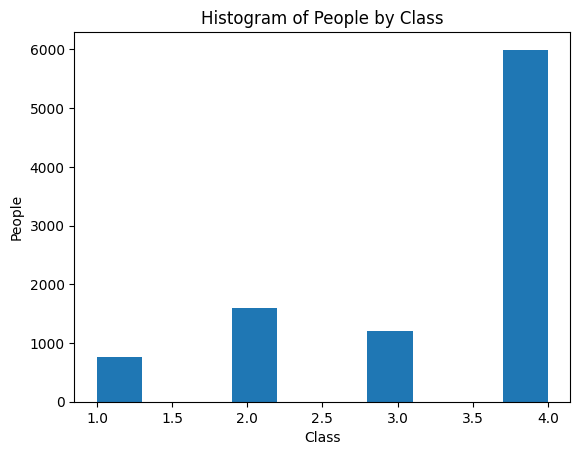

In [8]:
ax = csv_data[TARGET_COLUMN].hist()
ax.grid(False) 
ax.set_xlabel('Class')
ax.set_ylabel('People')
ax.set_title('Histogram of People by Class')

### ✅  Data Preparation

The data preparation will:
- Remove unnecessary columns (ID, Target, idhogar)
- Fill missing values with the median. Because the data is skewed, the median is a better choice than the mean.
- Encode categorical variables

> Note: *idhogar* is a unique identifier for each household.

To prepare the data we use `Pipeline` and `ColumnTransformer` from `sklearn`. It is possible to combine the estimator and the transformer in a single pipeline, but we will keep the data preparation and the model training separate as we will use the same data preparation for all models.

In [9]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from copy import deepcopy


def fill_and_encode(data):
    num_cols = data.select_dtypes(include=['int64', 'float64']).columns
    cat_cols = data.select_dtypes(include=['object', 'bool']).columns  

    num_transformer = SimpleImputer(strategy='median') 
    cat_transformer = Pipeline(steps=[
        ('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
        ('onehot', OneHotEncoder())
    ])

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', num_transformer, num_cols),
            ('cat', cat_transformer, cat_cols)
        ])

    pipeline = Pipeline(steps=[('preprocessor', preprocessor)])
    fit_data = pipeline.fit_transform(data)
    
    onehot_encoder = pipeline.named_steps['preprocessor'].named_transformers_['cat'].named_steps['onehot']
    onehot_cols = [f"{col}_{val}" for col, vals in zip(cat_cols, onehot_encoder.categories_) for val in vals]
    feature_names = np.append(num_cols, onehot_cols)
    return pd.DataFrame(fit_data, columns = feature_names)

def remove_columns(data):
    cols_to_remove = [ ID_COLUMN, TARGET_COLUMN, HOUSE_HOLD_ID_COLUMN ]
    for col in cols_to_remove:
        if col in data.columns:
            data = data.drop(columns = col)
    return data

def prepare(csv_path = None, data = None):
    if csv_path is None and data is None:
        raise ValueError("Either csv_path or data must be provided")
    if csv_path is not None and data is not None:
        raise ValueError("Only one of csv_path or data must be provided")
    raw_data = pd.read_csv(csv_path) if csv_path is not None else deepcopy(data)
    raw_data = remove_columns(raw_data)
    return fill_and_encode(raw_data)

In [10]:
csv_data.shape

(9557, 143)

In [11]:
TARGET = csv_data[TARGET_COLUMN]
DATA = prepare(data=csv_data)
TRAINING_FEATURES = DATA.columns
print(f"TARGET: {TARGET.shape} | DATA: {DATA.shape}")

TARGET: (9557,) | DATA: (9557, 212)


In [12]:
DATA.head()

,v2a1,hacdor,rooms,hacapo,v14a,refrig,v18q,v18q1,r4h1,r4h2,...,edjefa_21,edjefa_3,edjefa_4,edjefa_5,edjefa_6,edjefa_7,edjefa_8,edjefa_9,edjefa_no,edjefa_yes
0,190000.0,0.0,3.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,135000.0,0.0,4.0,0.0,1.0,1.0,1.0,1.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,130000.0,0.0,8.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,180000.0,0.0,5.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,180000.0,0.0,5.0,0.0,1.0,1.0,1.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [13]:
X_train, X_test, y_train, y_test = train_test_split(DATA, TARGET, test_size=DEFAULT_TEST_SIZE, random_state=DEFAULT_RANDOM_STATE)

In [14]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((6689, 212), (6689,), (2868, 212), (2868,))

### ✅ Sampling

The training data is imbalanced. There is sinnificantly higher number of data for class 4 than the other classes. This will be addressed by experimenting with different sampling. The oversampling will be done only on the training data. The test data will remain unchanged.

- **Oversampling:** will increase the number of data for the minority classes. For this we use the `RandomOverSampler` from the `imblearn` library.

- **Undersampling:** will decrease the number of data for the majority classes. For this we use the `RandomUnderSampler` from the `imblearn` library.

- **Over and Under Sampling** will increase the number of data for the minority classes and decrease the number of data for the majority classes. For this we use the `SMOTETomek` from the `imblearn` library.


In [15]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

def oversample(X, y):
    ros = RandomOverSampler(random_state=0)
    return ros.fit_resample(X, y)

def undersample(X, y):
    ros = RandomUnderSampler(random_state=0)
    return ros.fit_resample(X, y)

def smotsample(X, y):
    ros = SMOTETomek(sampling_strategy='auto')
    return ros.fit_resample(X, y)

Text(0.5, 1.0, 'People by Class (oversampled)')

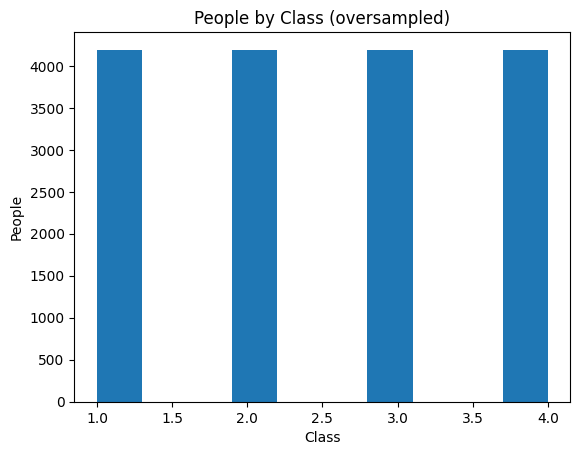

In [16]:
oversampled_X, oversampled_y = oversample(X_train, y_train)
ax = oversampled_y.hist()
ax.grid(False)
ax.set_xlabel('Class')
ax.set_ylabel('People')
ax.set_title('People by Class (oversampled)')

Text(0.5, 1.0, 'People by Class (undersampled)')

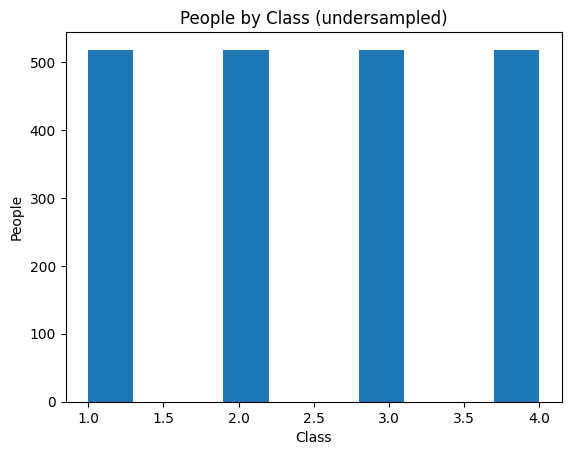

In [17]:
undersampled_X, undersampled_y = undersample(X_train, y_train)
ax = undersampled_y.hist()
ax.grid(False)
ax.set_xlabel('Class')
ax.set_ylabel('People')
ax.set_title('People by Class (undersampled)')

Text(0.5, 1.0, 'People by Class (smotsampled)')

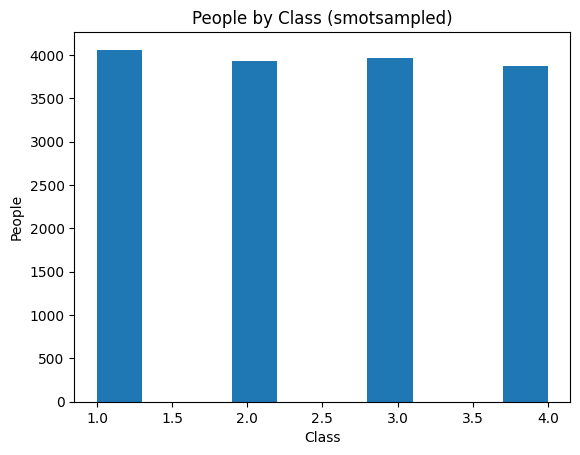

In [18]:
smotsampled_X, smotsampled_y = smotsample(X_train, y_train)
ax = smotsampled_y.hist()
ax.grid(False)
ax.set_xlabel('Class')
ax.set_ylabel('People')
ax.set_title('People by Class (smotsampled)')

### ✅ Ensemble learning

#### ✅ Shared Code

We would like to experiment with different models and different configuration and different hyperparameters. To ease the process and avoid code duplication we use reusable functions for:

- **Model training** 
- **Model evaluation**
- **Visualization**
- **Important features**

In the training the model we use `GridSearchCV` for hyperparameter tuning. The `GridSearchCV` will use weighted F1 score as the scoring function. The `GridSearchCV` will use 5-fold cross validation by default.

> Note: for `XGBoost` always transform the prediction using the encoder.

In [19]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb

def train_model(
    model, 
    train_x, 
    train_y, 
    param_grid = None, 
    boosting = 'not-xgb',
    encoder = None,
    test_size=DEFAULT_VALIDATION_SIZE, 
    cv = DEFAULT_CROSS_VALIDATION):

    if boosting == 'xgb' and encoder is None:
        raise ValueError("encoder must be provided for xgb boosting")

    X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=test_size, random_state=DEFAULT_RANDOM_STATE)

    if param_grid is not None:
        model = GridSearchCV(model, param_grid, cv=cv, scoring='f1_weighted', n_jobs=-1)

    model.fit(X_train, y_train if boosting != 'xgb' else encoder.fit_transform(y_train))
    
    predictions = model.predict(X_test)
    predictions = predictions if boosting != 'xgb' else encoder.inverse_transform(predictions)
    accuracy = accuracy_score(y_test, predictions)

    return model, accuracy

def important_features(trained_model):
    columns = TRAINING_FEATURES
    
    # if trained_model.__class__ == xgb.core.Booster:
    #     return pd.DataFrame(trained_model.get_score(importance_type='weight').items(),
    #                                     columns=['Feature','Importance']).sort_values('Importance', ascending=False)
        
    # if trained_model.__class__ == GridSearchCV:
    trained_model = trained_model.best_estimator_
    return pd.DataFrame(trained_model.feature_importances_,
                                index = columns,
                                columns=['importance']).sort_values('importance', ascending=False)

#### ✅ AdaBoost

In [20]:
ada_boost_param_grid = {
    # run this when you have time
    'learning_rate': [0.01, 0.05, 0.25, 0.5, 1],
    'estimator__max_depth': [2 , 3, 5, 7, 10],
    'estimator__min_samples_leaf': [3, 5, 10, 20]

    # 'learning_rate': [0.01],
    # 'estimator__max_depth': [3],
    # 'estimator__min_samples_leaf': [5]
}

ada_boost_model, training_accuracy = train_model(AdaBoostClassifier(estimator=DecisionTreeClassifier()), oversampled_X, oversampled_y, param_grid=ada_boost_param_grid)
print(f"Best parameters: \n{ada_boost_model.best_params_}")

Best parameters: 
{'estimator__max_depth': 10, 'estimator__min_samples_leaf': 5, 'learning_rate': 0.5}


In [21]:
print(f"AdaBoost training accuracy: {training_accuracy}")

AdaBoost training accuracy: 0.9892665474060823


In [22]:
pd.DataFrame(ada_boost_model.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_estimator__max_depth,param_estimator__min_samples_leaf,param_learning_rate,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,1.751443,0.057913,0.055461,0.002185,2,3,0.01,"{'estimator__max_depth': 2, 'estimator__min_sa...",0.436781,0.445605,0.441123,0.436499,0.449637,0.441929,0.005090,97
1,2.131603,0.630772,0.071075,0.023848,2,3,0.05,"{'estimator__max_depth': 2, 'estimator__min_sa...",0.507036,0.514277,0.488879,0.507107,0.520793,0.507618,0.010674,89
2,1.766190,0.164900,0.064586,0.022361,2,3,0.25,"{'estimator__max_depth': 2, 'estimator__min_sa...",0.571068,0.577290,0.552300,0.572124,0.582546,0.571065,0.010235,79
3,1.815308,0.133902,0.063692,0.010016,2,3,0.5,"{'estimator__max_depth': 2, 'estimator__min_sa...",0.560258,0.584882,0.558594,0.571206,0.577514,0.570491,0.010032,81
4,1.666590,0.028155,0.056006,0.001717,2,3,1,"{'estimator__max_depth': 2, 'estimator__min_sa...",0.569218,0.569481,0.570132,0.554806,0.561249,0.564977,0.006036,86
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,5.685067,0.180031,0.063373,0.003440,10,20,0.01,"{'estimator__max_depth': 10, 'estimator__min_s...",0.967248,0.963496,0.967188,0.956240,0.958767,0.962588,0.004441,23
96,5.796123,0.161890,0.060987,0.002605,10,20,0.05,"{'estimator__max_depth': 10, 'estimator__min_s...",0.967356,0.961637,0.977860,0.959326,0.976589,0.968554,0.007558,16
97,6.758198,0.959239,0.082318,0.022194,10,20,0.25,"{'estimator__max_depth': 10, 'estimator__min_s...",0.965774,0.963656,0.966346,0.964290,0.957215,0.963456,0.003268,21
98,6.018837,0.048362,0.061950,0.000803,10,20,0.5,"{'estimator__max_depth': 10, 'estimator__min_s...",0.963313,0.963162,0.963434,0.967346,0.957713,0.962994,0.003071,22


In [23]:
important_features(ada_boost_model).head(20)

,importance
paredblolad,0.205808
SQBdependency,0.072095
meaneduc,0.041607
SQBmeaned,0.038474
epared2,0.037369
SQBovercrowding,0.034709
r4m1,0.029104
edjefa_5,0.029081
SQBescolari,0.024750
overcrowding,0.024392


[1 2 3 4]


<Figure size 2000x2000 with 0 Axes>

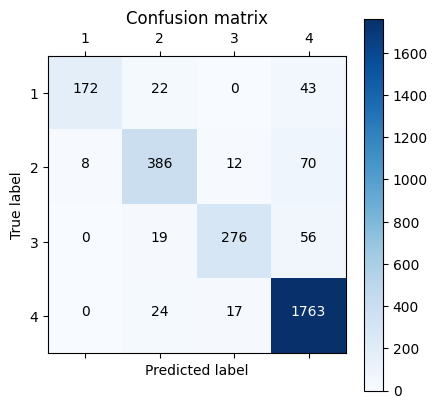

In [24]:
plot_confusion_matrix(ada_boost_model, X_test, y_test)

#### ✅ Gradient Boosting

In [25]:
gradient_boost_param_grid = {
    # Run this at before going to sleep
    'learning_rate': [0.01, 0.05, 0.1, 0.2125, 0.5],
    'max_depth': [3, 5, 7, 10],
    'min_samples_leaf': [5, 10, 20],
    'n_estimators': [100, 200, 300, 400, 500],
    
    # 'learning_rate': [0.1],
    # 'max_depth': [3],
    # 'min_samples_leaf': [5]
}

gradient_boost_model, training_accuracy = train_model(GradientBoostingClassifier(), undersampled_X, undersampled_y, param_grid=gradient_boost_param_grid)
print(f"GradientBoost training accuracy: {training_accuracy}")


In [ ]:
important_features(gradient_boost_model).head(20)

,importance
SQBdependency,0.075302
meaneduc,0.067172
SQBmeaned,0.063076
qmobilephone,0.044834
v2a1,0.038586
r4t1,0.037040
SQBhogar_nin,0.035414
r4h2,0.031987
rooms,0.031622
SQBedjefe,0.024888


[1 2 3 4]


<Figure size 2000x2000 with 0 Axes>

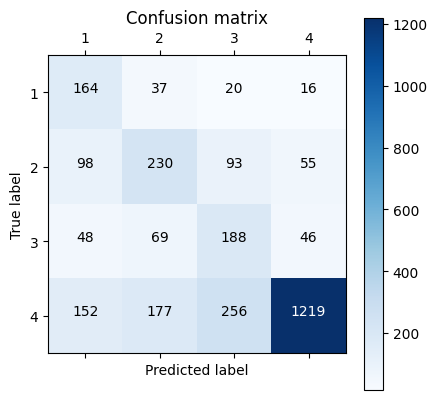

In [ ]:
plot_confusion_matrix(gradient_boost_model, X_test, y_test)

#### ✅ XGBoost

In [ ]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

xgb_param_grid = {
    # Run this at before going to sleep
    'n_estimators': [100, 200, 300, 500, 1000],
    'max_depth': [2, 5, 10, 15, 20],
    'learning_rate': [0.01, 0.06, 0.1, 0.2125, 0.5, 1],
    'objective': ['multi:softmax', 'multi:softprob', 'multi:logistic'],
    'num_class': [4],
    'eval_metric': ['merror', 'mlogloss'],

    # 'n_estimators': [1000],
    # 'learning_rate': [0.1],
    # 'objective': ['multi:softmax'],
    # 'num_class': [4],
    # 'eval_metric': ['merror'],
}


xgb_model, training_accuracy = train_model(
    # XGBClassifier(objective='multi:softmax', num_class=4, eval_metric='mlogloss'), 
    XGBClassifier(), 
    oversampled_X, 
    oversampled_y, 
    param_grid=xgb_param_grid, 
    boosting='xgb', 
    encoder=le
)
print(f"Best parameters: \n{xgb_model.best_params_}")

Best parameters: 
{'eval_metric': 'merror', 'learning_rate': 0.1, 'n_estimators': 1000, 'num_class': 4, 'objective': 'multi:softmax'}


In [ ]:
print(f"XGBoost training accuracy: {training_accuracy}")

XGBoost training accuracy: 0.9835022858278673


In [ ]:
important_features(xgb_model).head(20)

,importance
dependency_.2,0.025960
edjefe_15,0.014364
techozinc,0.014292
v18q,0.014273
dependency_4,0.013664
edjefe_17,0.013404
edjefa_17,0.012634
tipovivi2,0.012354
dependency_3,0.012198
pareddes,0.012087


In [ ]:
def hetrogeneous_ensemble_with_cnn(ada_boost_model, gradient_boost_model, xgb_model, train_x, train_y):
    X_train, X_test, y_train, y_test = train_test_split(train_x, train_y, test_size=0.4, random_state=42)
    # TODO: combination of ensemble models with CNN

In [ ]:
y_test

596     4
9217    4
3489    1
6972    4
5783    3
       ..
7526    1
9155    4
452     4
3387    2
90      4
Name: Target, Length: 2868, dtype: int64

In [ ]:
def plot_pr_curve(model, test_x, test_y):
    predictions = model.predict_proba(test_x)
    precision, recall, _ = precision_recall_curve(test_y, predictions[:, 1])
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.show()

def plot_roc_curve(model, test_x, test_y):
    predictions = model.predict_proba(test_x)
    fpr, tpr, _ = roc_curve(test_y, predictions[:, 1])
    plt.plot(fpr, tpr)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.show()    

## Tasks
- ✅ A working setup for Ensemble learning with AdaBoost, Gradient Boosting and XGBoost
- ✅ Feature importance for the different models
- ✅ Compare the different models accuracy
- ✅ Add different data preprocessing methods
- ✅ Balance dataset by undersampling, and possibly oversampling

- ❌ Test all models with different sampling methods
- ❌ Find optimum parameter for the different models
- ❌ Performance Metric
- ❌ Experiment with heterogeneous ensemble with simple CNN